# 敏感与拮抗药物 IC50-ZScore 散点图

## 1. 数据预处理

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

In [2]:
df_cell_blind = pd.read_csv('drug_sensitivity_MixedSet_Erlotinib_test&prediction.csv',index_col=0)
print(df_cell_blind.shape)
df_cell_blind.head(1)

(12485, 5)


,drug,cell_line,OncotreeCode,IC50,prediction
0,AZD5582,22RV1,PRAD,2.402949,1.643723


In [3]:
df_gdsc = pd.read_csv('df_gdsc_StrippedCellLineName.csv',index_col=0)[['Drug Name','Cell Line Name','Z score']]
# 将df_gdsc的Drug Name，Cell Line Name改为drug和cell_line
df_gdsc.columns = ['drug','cell_line','Z score']
# 将存在drug，cell_line重复的数据取平均
df_gdsc = df_gdsc.groupby(['drug','cell_line']).mean().reset_index()
print(df_gdsc.shape)
df_gdsc.head(1)

(236845, 3)


,drug,cell_line,Z score
0,123138,22RV1,-0.257761


In [4]:
df_drug_target = pd.read_csv('GDSC2_Drug_Pathway_Target.csv',index_col=0)[['Drug name','Drug target','Target Pathway']]
# 将Drug name改为drug
df_drug_target.columns = ['drug','Drug target','Target Pathway']
# 将存在drug重复的数据删除
df_drug_target = df_drug_target.drop_duplicates(subset='drug')
print(df_drug_target.shape)
df_drug_target.head(1)

(288, 3)


,drug,Drug target,Target Pathway
0,123138,NaN,Unclassified


In [11]:
df_gdsc_mean_std = pd.read_csv('gdsc_drug_mean_std.csv')
df_gdsc_mean_std.columns = ['drug','mean','std']
df_gdsc_mean_std.head(1)

,drug,mean,std
0,123138,2.898762,0.831312


In [5]:
# 将df_cell_blind和df_gdsc合并，按照drug和cell_line合并,df_cell_blind为主
df = pd.merge(df_cell_blind,df_gdsc,on=['drug','cell_line'],how='inner')
print(df.shape)
df.head(1)

(12485, 6)


,drug,cell_line,OncotreeCode,IC50,prediction,Z score
0,AZD5582,22RV1,PRAD,2.402949,1.643723,0.104758


In [6]:
# 将df和df_drug_target合并，按照drug合并,df为主
df = pd.merge(df,df_drug_target,on='drug',how='inner')
print(df.shape)
df.head(1)

(12485, 8)


,drug,cell_line,OncotreeCode,IC50,prediction,Z score,Drug target,Target Pathway
0,AZD5582,22RV1,PRAD,2.402949,1.643723,0.104758,"XIAP, cIAP",Apoptosis regulation


In [7]:
# 新增一个属性，Type，表示是否为敏感或者拮抗药物，Z score=>2为拮抗，Z score<=-2为敏感，否则为中性
df['Type'] = 'Neutral'
df.loc[df['Z score']<=-2,'Type'] = 'Sensitive'
df.loc[df['Z score']>=2,'Type'] = 'Resistant'
df.head(1)

,drug,cell_line,OncotreeCode,IC50,prediction,Z score,Drug target,Target Pathway,Type
0,AZD5582,22RV1,PRAD,2.402949,1.643723,0.104758,"XIAP, cIAP",Apoptosis regulation,Neutral


## 2. 挑选合适的数据

In [8]:
# 统计每个cell_line的敏感，拮抗，中性药物数量
df_count = df.groupby(['drug','Type']).size().unstack().fillna(0)
df_count['Total'] = df_count.sum(axis=1)
df_count = df_count.sort_values(by='Total',ascending=False)
df_count.head(100)

Type,Neutral,Resistant,Sensitive,Total
drug,,,,
Erlotinib,79.0,0.0,4.0,83.0
Uprosertib,74.0,0.0,3.0,77.0
Navitoclax,74.0,0.0,3.0,77.0
JQ1,73.0,2.0,1.0,76.0
GSK591,73.0,0.0,2.0,75.0
...,...,...,...,...
P22077,55.0,2.0,1.0,58.0
MK-8776,56.0,1.0,1.0,58.0
Temozolomide,56.0,1.0,0.0,57.0


In [9]:
# 取出df中drug为这些药物的数据 可用数据：SCH772984 AZD5991(DLBCLNOS) 
df_single_drug = df[df['drug']=='AZD5991']
# 根据Z score排序
df_single_drug = df_single_drug.sort_values(by='Z score',ascending=True)
df_single_drug.head(500)

,drug,cell_line,OncotreeCode,IC50,prediction,Z score,Drug target,Target Pathway,Type
362,AZD5991,A3KAW,DLBCLNOS,-3.139455,-2.348238,-2.457335,MCL1,Apoptosis regulation,Sensitive
2273,AZD5991,DOHH2,DLBCLNOS,-3.008037,-3.079731,-2.410473,MCL1,Apoptosis regulation,Sensitive
4854,AZD5991,KASUMI1,AML,-2.462916,-1.343383,-2.216089,MCL1,Apoptosis regulation,Sensitive
435,AZD5991,A4FUK,DLBCLNOS,-2.347430,-2.560685,-2.174908,MCL1,Apoptosis regulation,Sensitive
9857,AZD5991,RS411,BLL,-1.598199,0.990665,-1.907740,MCL1,Apoptosis regulation,Neutral
7093,AZD5991,NCIH1581,LCLC,-1.133650,-0.289723,-1.742087,MCL1,Apoptosis regulation,Neutral
9406,AZD5991,PFSK1,PNET,-0.966652,-0.115501,-1.682537,MCL1,Apoptosis regulation,Neutral
8513,AZD5991,NOS1,OS,-0.629789,-0.281855,-1.562415,MCL1,Apoptosis regulation,Neutral
2196,AZD5991,DMS273,SCLC,-0.442005,-0.363754,-1.495454,MCL1,Apoptosis regulation,Neutral
3914,AZD5991,HSC2,OCSC,-0.032323,4.407897,-1.349365,MCL1,Apoptosis regulation,Neutral


In [15]:
# 计算predicted LN IC50 Z-Score
df_gdsc_mean_std = df_gdsc_mean_std[df_gdsc_mean_std['drug']=='AZD5991']
mean = df_gdsc_mean_std['mean'].values[0]
std = df_gdsc_mean_std['std'].values[0]
df_single_drug['predicted_Z-Score'] = (df_single_drug['prediction'] - mean) / std
df_single_drug.head(500)

,drug,cell_line,OncotreeCode,IC50,prediction,Z score,Drug target,Target Pathway,Type,predicted_Z-Score
362,AZD5991,A3KAW,DLBCLNOS,-3.139455,-2.348238,-2.457335,MCL1,Apoptosis regulation,Sensitive,-2.175196
2273,AZD5991,DOHH2,DLBCLNOS,-3.008037,-3.079731,-2.410473,MCL1,Apoptosis regulation,Sensitive,-2.436038
4854,AZD5991,KASUMI1,AML,-2.462916,-1.343383,-2.216089,MCL1,Apoptosis regulation,Sensitive,-1.816875
435,AZD5991,A4FUK,DLBCLNOS,-2.347430,-2.560685,-2.174908,MCL1,Apoptosis regulation,Sensitive,-2.250952
9857,AZD5991,RS411,BLL,-1.598199,0.990665,-1.907740,MCL1,Apoptosis regulation,Neutral,-0.984579
7093,AZD5991,NCIH1581,LCLC,-1.133650,-0.289723,-1.742087,MCL1,Apoptosis regulation,Neutral,-1.441151
9406,AZD5991,PFSK1,PNET,-0.966652,-0.115501,-1.682537,MCL1,Apoptosis regulation,Neutral,-1.379025
8513,AZD5991,NOS1,OS,-0.629789,-0.281855,-1.562415,MCL1,Apoptosis regulation,Neutral,-1.438346
2196,AZD5991,DMS273,SCLC,-0.442005,-0.363754,-1.495454,MCL1,Apoptosis regulation,Neutral,-1.467550
3914,AZD5991,HSC2,OCSC,-0.032323,4.407897,-1.349365,MCL1,Apoptosis regulation,Neutral,0.233970


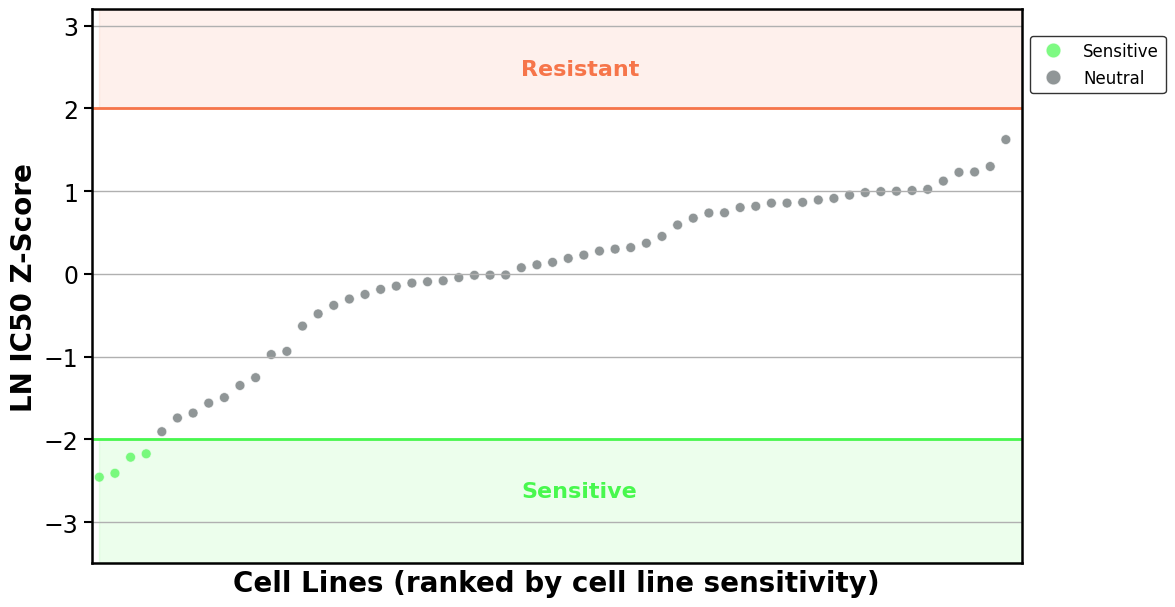

In [11]:
# 设置全局字体
plt.rcParams['font.sans-serif'] = ['Bahnschrift']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')
palette = {
    'Sensitive': '#48F84E',
    'Neutral': '#616A6B',
    'Resistant': '#F6754A'
}
# 以Z score为y轴，drug为x轴，Type为颜色，绘制散点图
plt.figure(figsize=(12, 7.2))
# Y轴设置网格
plt.grid(axis='y', alpha=1, linestyle='-', linewidth=1)
sns.scatterplot(x='cell_line', y='Z score', hue='Type', data=df_single_drug, s=50, alpha=0.7, palette=palette)
plt.ylabel('LN IC50 Z-Score', fontsize=20, fontweight='bold')
plt.xlabel('Cell Lines (ranked by cell line sensitivity)', fontsize=20, fontweight='bold')
# 将legend放在画布外
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9), fontsize=12, markerscale=1.5, edgecolor='black')
plt.xticks([])
plt.yticks(fontsize=17)
plt.axhline(2, color='#F6754A', linewidth=2, linestyle='-')
plt.axhline(-2, color='#48F84E', linewidth=2, linestyle='-')
# 将Y小于-2整个画布涂色
plt.fill_between([0, df_single_drug.shape[0]], -2, -3.5, color='#48F84E', alpha=0.1)
# 在Y小于-2的区域写字：Sensitive
plt.text(27, -2.7, 'Sensitive', fontsize=16, color='#48F84E', fontweight='bold')
# 将大于2整个画布涂色
plt.fill_between([0, df_single_drug.shape[0]], 2, 3.5, color='#F6754A', alpha=0.1)
# 在Y大于2的区域写字：Resistant
plt.text(27, 2.4, 'Resistant', fontsize=16, color='#F6754A', fontweight='bold')
# 去除上和右边框
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# 刻度加粗
plt.gca().tick_params(width=1.5, length=6)
plt.xlim(left=-0.5, right=df_single_drug.shape[0])
plt.ylim(bottom=-3.5, top=3.2)
# 加粗横纵坐标
plt.gca().spines['bottom'].set_linewidth(1.8)
plt.gca().spines['left'].set_linewidth(1.8)
plt.gca().spines['right'].set_linewidth(1.8)
plt.gca().spines['top'].set_linewidth(1.8)

# plt.savefig('敏感与拮抗药物_IC50-ZScore散点图(Mixed-Set).png', dpi=300, bbox_inches='tight')
plt.show()
